In [1]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import time
import torchvision
BATCH_SIZE = 256
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_trans = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70,70)), #resizing images so they work with the AlexNet architecture
    torchvision.transforms.RandomCrop((64,64)), ## crops a random 64x64 space to avoid the model overfitting the data
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

test_trans = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70,70)),
    torchvision.transforms.CenterCrop((64,64)), # Now we center crop as we are not training the data
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_trans)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_trans)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

class_labels = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']

Files already downloaded and verified
Files already downloaded and verified


In [2]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [3]:
model = AlexNet()
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct / total * 100  # Return accuracy as percentage

# Training loop
num_epochs = 10

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

start_time = time.time()  # Record start time for training

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
        total += labels.size(0)
        
    train_loss = running_loss / len(trainloader)
    train_accuracy = accuracy(outputs, labels)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(testloader)
    val_accuracy = accuracy(outputs, labels)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    end_time = time.time()  # Record end time for each epoch
    elapsed_time = end_time - start_time  # Calculate elapsed time for each epoch
    
    print("----------------------------------------------------")
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f" | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | ")
    print(f" | Val Loss: {val_loss:.4f}   | Val Acc: {val_accuracy:.2f}%   | ")
    print(f"Time: {elapsed_time:.2f} seconds")
    print("----------------------------------------------------")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training finished in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")


----------------------------------------------------
Epoch [1/10]
 | Train Loss: 1.9359 | Train Acc: 42.50% | 
 | Val Loss: 1.7557   | Val Acc: 31.25%   | 
Time: 52.78 seconds
----------------------------------------------------
----------------------------------------------------
Epoch [2/10]
 | Train Loss: 1.5998 | Train Acc: 45.00% | 
 | Val Loss: 1.3982   | Val Acc: 50.00%   | 
Time: 105.31 seconds
----------------------------------------------------
----------------------------------------------------
Epoch [3/10]
 | Train Loss: 1.3999 | Train Acc: 51.25% | 
 | Val Loss: 1.4102   | Val Acc: 50.00%   | 
Time: 157.55 seconds
----------------------------------------------------
----------------------------------------------------
Epoch [4/10]
 | Train Loss: 1.3111 | Train Acc: 52.50% | 
 | Val Loss: 1.2307   | Val Acc: 50.00%   | 
Time: 208.59 seconds
----------------------------------------------------
----------------------------------------------------
Epoch [5/10]
 | Train Loss: 

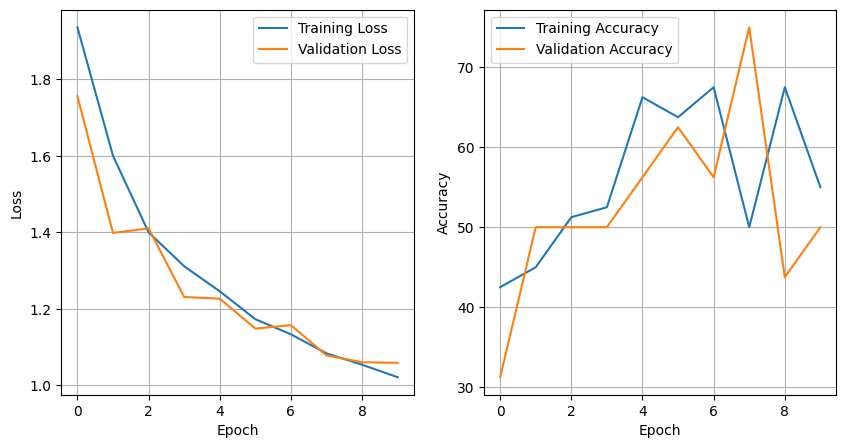

In [4]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [8]:
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

57044810
